In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load your dataset & Select more columns for features
df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment', 'airline', 'negativereason']]
df = df.dropna(subset=['text', 'airline_sentiment']) 

In [3]:
# 2. Text cleaning
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)         # remove @mentions
    text = re.sub(r"#", "", text)            # remove # symbol
    text = re.sub(r"[^A-Za-z\s]", " ", text) # keep only letters
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Combine text + negativereason (if available)
df['negativereason'] = df['negativereason'].fillna("")
df['full_text'] = (df['text'] + " " + df['negativereason']).apply(clean_text)

In [4]:
# 3. Train / test split
X = df['full_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# 4. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [6]:
# 5. Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
# 6. Evaluation
y_pred = logreg.predict(X_test_tfidf)

print("=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

=== Logistic Regression Performance ===
Accuracy: 0.9183743169398907

              precision    recall  f1-score   support

    negative       0.97      1.00      0.99      1835
     neutral       0.80      0.87      0.83       620
    positive       0.86      0.67      0.75       473

    accuracy                           0.92      2928
   macro avg       0.88      0.85      0.86      2928
weighted avg       0.92      0.92      0.92      2928



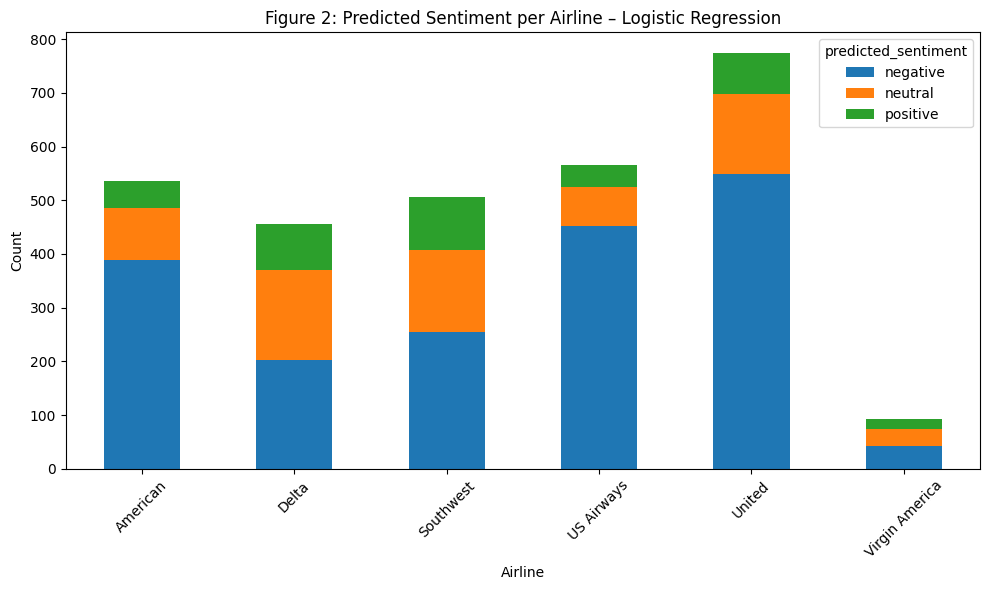

In [8]:
#7. Airline-level sentiment distribution (optional)

X_test_df = X_test.to_frame()
X_test_df['true_sentiment'] = y_test.values
X_test_df['predicted_sentiment'] = y_pred
X_test_df['airline'] = df.loc[X_test.index, 'airline'].values

airline_sentiment = (
    X_test_df
    .groupby(['airline', 'predicted_sentiment'])
    .size()
    .unstack(fill_value=0)
)

airline_sentiment.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Figure 2: Predicted Sentiment per Airline – Logistic Regression")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
labels = ['negative', 'neutral', 'positive']

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

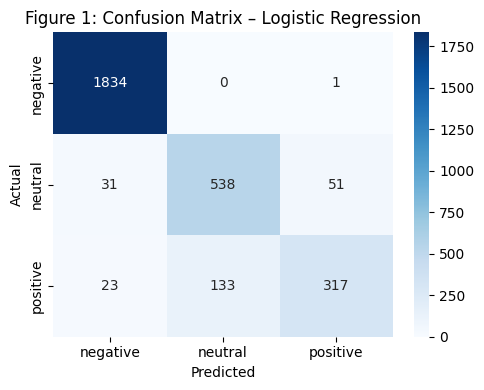

In [10]:
plot_confusion_matrix(y_test, y_pred, "Figure 1: Confusion Matrix – Logistic Regression")